In [1]:
import numpy as np # linear algebra
run = 0
np.random.seed(run)
import os, glob, re
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale

from sklearn import metrics
from torch.utils.data import ConcatDataset, sampler, DataLoader #*
from eval_utils import logger, do_eval_binary, do_eval_binary_sky
from data_utils import ParquetDataset
from network_utils import *

import ROOT
from array import array

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline
#plt.switch_backend('agg')
#plt.rcParams["figure.figsize"] = (5,5)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Welcome to JupyROOT 6.24/06


In [2]:
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # :0 is always first *visible* device
#device = torch.device("cpu")

In [3]:
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premax16-fmaps4-8-16-blocks3_epochs50-ntrain72k-lr5Em04_run1' #epoch32,29
#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-16-blocks3-kernel3-down2_epochs50-ntrain72k-lr5Em04_run0' #epoch24,25
expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch18,27

#expt_name = 'BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp_resnet-scale5.0-shiftTrue-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0' #epoch21

epoch = 27
scale = float(re.search('scale([0-9]+?.[0-9]+?)-', expt_name).group(1))
#nblocks = int(re.search('blocks([0-9]+?)_', expt_name).group(1))
nblocks = int(re.search('blocks([0-9]+?)-', expt_name).group(1))
#premax = int(re.search('premax([0-9]+?)-', expt_name).group(1))
premax = None

shift = True if 'nobp' in expt_name else False

#down = args.down
#fmaps = [4, 6, 8, 12, 16] # Resnet_deep
fmaps = [4, 6, 8, 12] # Resnet_stride
#fmaps = [4, 8, 16] # Resnet_premax
#fmaps = [8, 16, 32]
#fmaps = [24, 48, 96]
#premax = 64 # 2s->128
#premax = 16# 0.5s->128

print(scale, nblocks, premax)
#'''
model_file = glob.glob('MODELS/%s/model_epoch%d_auc*.pkl'%(expt_name, epoch))
print(model_file)
assert len(model_file) == 1
model_file = model_file[0]
print(">> Model file:", model_file)
'''
###################################################################
# Network architecture
#model = ResNet(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3, debug=debug)
if premax is None:
    if len(fmaps) == 5:
        logger(f, '>> Model: Resnet_deep')
        model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=kernel, debug=debug)
    else:
        logger(f, '>> Model: Resnet_stride')
        model = ResNet_stride(in_channels=1, nblocks=nblocks, fmaps=fmaps, down=down, kernel=kernel, debug=debug)
else:
    logger(f, '>> Model: Resnet_premax')
    model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=kernel, debug=debug)
'''
#model = ResNet_deep(in_channels=1, nblocks=nblocks, fmaps=fmaps, kernel=3)
model = ResNet_stride(in_channels=1, nblocks=nblocks, fmaps=fmaps, down=3, kernel=7)
#model = ResNet_premax(in_channels=1, nblocks=nblocks, fmaps=fmaps, premax=premax, kernel=3)
model.to(device)#.cuda()
model.load_state_dict(torch.load('%s'%model_file)['model'])

optimizer = optim.Adam(model.parameters(), lr=5.e-4) # not used, but needed by eval fn when making checkpoint

2.0 3 None
['MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl']
>> Model file: MODELS/BBH-H1-m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_resnet-scale2.0-premaxNone-fmaps4-6-8-12-blocks3-kernel7-down3_epochs50-ntrain72k-lr5Em04_run0/model_epoch27_auc0.9960.pkl


In [4]:
run = 0
np.random.seed(run)
###################################################################
# Load data
scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s'
#scenario = 'm20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s_nobp'
# Get parquet files
pqfiles = glob.glob('data/O1/parquet/%s/*_H1_*.parquet'%scenario)
print('>> Input files: %s'%(' '.join(pqfiles)))
dset_train = ConcatDataset([ParquetDataset(pqf, scale, shift, ndet=1) for pqf in pqfiles])
print(len(dset_train))

idxs = np.random.permutation(len(dset_train))
print('>> Random(10): %s'%(' '.join([str(n) for n in np.random.permutation(10)])))
n_train = 72000
if n_train != -1:
    assert n_train <= len(idxs)
    idxs_train = idxs[:n_train]
    idxs_val = idxs[n_train:]

# Test set _______________________________________________________________________
val_sampler = sampler.SubsetRandomSampler(idxs_val)
val_loader = DataLoader(dataset=dset_train, batch_size=32, num_workers=2, sampler=val_sampler)

>> Input files: data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1_local_idx004_bg.parquet data/O1/parquet/m20to50_d1E2to5E2_teff0.5s_tw4.5s_ts0.5s/O1_H1_local_idx004_sgbg.parquet
179952
>> Random(10): 4 5 7 3 6 8 9 0 2 1


In [5]:
aucs = []
tpr_fpr0s = []
losses = []
debug = False

#losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s = \
#do_eval_binary(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=False, write_model=False)

losses, aucs, tpr_fpr0s, fprs, tprs, thrs, y_trues, y_preds, y_probs, dists, m1s, m2s, decs, ras, nnouts = \
do_eval_binary_sky(model, optimizer, device, val_loader, expt_name, epoch, losses, aucs, tpr_fpr0s, f=open('/dev/null', 'w'), debug=debug, write_model=False)

losses, aucs, tpr_fpr0s = np.array(losses), np.array(aucs), np.array(tpr_fpr0s)
print('>> Best Loss:%4.3E +/- %4.3E @ epoch:%d'%(np.min(losses), np.min(losses)/np.sqrt(len(idxs_val)), np.argwhere(losses==np.min(losses))[0][0]+1))
print('>> Best AUC:%4.3f +/- %4.3f @ epoch:%d'%(np.max(aucs), np.max(aucs)/np.sqrt(len(idxs_val)), np.argwhere(aucs==np.max(aucs))[0][0]+1))
print('>> Best TPR@FPR=0:%4.3f +/- %4.3f @ epoch:%d'%(np.max(tpr_fpr0s), np.max(tpr_fpr0s)/np.sqrt(len(idxs_val)*np.max(tpr_fpr0s)/2.), np.argwhere(tpr_fpr0s==np.max(tpr_fpr0s))[0][0]+1))

27: (0/3374) ...
27: (674/3374) ...
27: (1348/3374) ...
27: (2022/3374) ...
27: (2696/3374) ...
27: (3370/3374) ...
27: Val time:181.43s in 3374 steps for N:107952 samples
27: Val loss:0.039045, auc:0.995975, TPR@FPR=0:0.979178
>> Best Loss:3.904E-02 +/- 1.188E-04 @ epoch:1
>> Best AUC:0.996 +/- 0.003 @ epoch:1
>> Best TPR@FPR=0:0.979 +/- 0.004 @ epoch:1


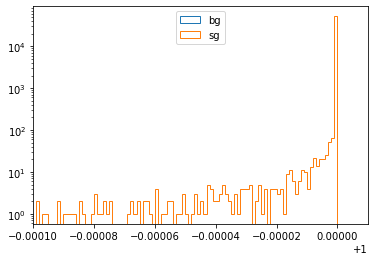

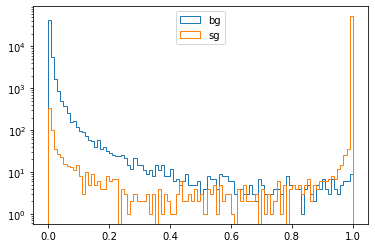

2.497466455864128e-09


In [6]:
#print(y_trues.shape, y_probs.shape)
nbins=100
xrange = [0.9999, 1.]
plt.hist(y_probs[y_trues==0], histtype='step', range=xrange, bins=nbins, label='bg')
plt.hist(y_probs[y_trues==1], histtype='step', range=xrange, bins=nbins, label='sg')
plt.xlim([0.9999, 1.00001])
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
plt.show()

plt.hist(y_probs[y_trues==0], histtype='step', range=(0.,1.), bins=nbins, label='bg')
plt.hist(y_probs[y_trues==1], histtype='step', range=(0.,1.), bins=nbins, label='sg')
#plt.xlim([0.9999, 1.00001])
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
plt.show()

print(y_probs[y_trues==0].min())

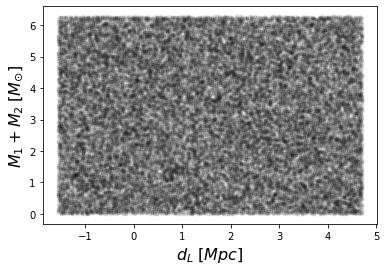

In [7]:
plt.plot(decs[y_trues==1], ras[y_trues==1], ".", color='black', alpha=0.05, label='p')
plt.ylabel(r'$M_1 + M_2\;[M_{\odot}]$', size=16)
#plt.ylim([20.,1.e2])
plt.xlabel(r'$d_L\;[Mpc]$', size=16)
#plt.xlim([500.,1.e3])
plt.show()

In [8]:
from math import ceil, floor
def float_round(num, places = 0, direction = ceil):
    return direction(num * (10**places)) / float(10**places)

2157
tpr: [0.         0.96172614 0.96440811 ... 0.99998138 0.99998138 1.        ]
fpr: [0.         0.         0.         ... 0.99998157 1.         1.        ]
thr: [2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 1.62634905e-07
 2.49746646e-09 5.45696517e-13]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


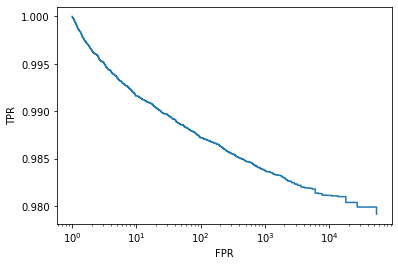

1.8429782528566162e-05
102 1.8429782528566162e-05 0.9985992312431335 0.9791775311033301
1.8429782528566162e-05
54260.0
4.73448


In [9]:
# see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, thr = metrics.roc_curve(y_trues, y_probs)
print(len(fpr))
print('tpr:', tpr)
print('fpr:', fpr)
print('thr:', thr)
plt.plot(1./fpr, tpr, label=r'AUC = %0.2f'%(aucs[0])) #lw=2, alpha=.8))
#plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.ylim([0.9, 1.01])
#plt.xlim([1.e3, 1./5.e-5])#1./5.56096205e-05])
plt.xscale('log')
plt.show()

# Get index just before FPR drops to 0
#idx = np.argwhere(fpr>1.e-4)[0]
fprmin = fpr[fpr>0.].min()
print(fprmin)
idx = np.argwhere(fpr>=fprmin)[0][0]
#idx = np.argwhere(fpr==0.)[-1][0]+1
idx = np.argwhere(fpr==0.)[-1][0]+1
print(idx, fpr[idx], thr[idx], tpr[idx])
print(fpr[idx])
print(1./fpr[idx])
thr_fprinvmax = thr[idx]
# Get log equivalent of FPR min / FRPinv max
fprinv_max = 1./fpr[idx]
fprinv_logmax = np.log10(fprinv_max)
fprinv_logmax = float_round(fprinv_logmax, 5) # needed to control rounding errors which can give wrong critical bin below
print(fprinv_logmax)

In [10]:
# Now determine coarse-binned thresholds based on user-defined FPR values

# Specify user-defined FPR edges
# Set upper limit to value where FPR drops to 0
# i.e. value where 1./FPR is max
fpr_edges = 1./np.logspace(0, fprinv_logmax, num=6*2)
fpr_edges = np.concatenate([[0.], fpr_edges[::-1]])
#fpr_edges = fpr_edges[::-1]
print(fpr_edges)

# may not be satisfied due to rounding errors
assert fpr_edges[1] <= fpr[idx], '%E vs %E'%(fpr_edges[1], fpr[idx])

# Get corresponding prob thresholds from full threshold list
# Get idxs
thr_idxs = np.array([np.argwhere(fpr>=e)[0][0] for e in fpr_edges])#-1
#thr_idxs = np.array([np.argwhere(fpr>=e)[0][0] for e in fpr_edges])-3
#thr_idxs[0] = 0
#thr_idxs[1] = 3
print('coarse idxs:',thr_idxs)
print('coarse FPRs:',fpr[thr_idxs])
print('coarse 1/FPRs:',1./fpr[thr_idxs])
print('coarse TPRs:',tpr[thr_idxs])
# Get prob thresholds
thr_coarse = thr[thr_idxs]
print('coarse prob thresh:',thr_coarse)

[0.00000000e+00 1.84297736e-05 4.96509169e-05 1.33762552e-04
 3.60364348e-04 9.70843195e-04 2.61550987e-03 7.04634067e-03
 1.89832649e-02 5.11420558e-02 1.37779770e-01 3.71186974e-01
 1.00000000e+00]
coarse idxs: [   0  102  108  118  138  182  268  392  564  764  999 1380 2155]
coarse FPRs: [0.00000000e+00 1.84297825e-05 5.52893476e-05 1.47438260e-04
 3.87025433e-04 9.76778474e-04 2.61702912e-03 7.09546627e-03
 1.99963140e-02 5.21931441e-02 1.38757833e-01 3.71489126e-01
 1.00000000e+00]
coarse 1/FPRs: [           inf 5.42600000e+04 1.80866667e+04 6.78250000e+03
 2.58380952e+03 1.02377358e+03 3.82112676e+02 1.40935065e+02
 5.00092166e+01 1.91596045e+01 7.20680037e+00 2.69186883e+00
 1.00000000e+00]
coarse TPRs: [0.         0.97917753 0.98040676 0.981338   0.98249274 0.9836661
 0.98515608 0.9868323  0.98858303 0.99048275 0.99266185 0.99539969
 0.99998138]
coarse prob thresh: [2.00000000e+00 9.98599231e-01 9.96666014e-01 9.91569877e-01
 9.73859429e-01 9.05350924e-01 6.82808220e-01 3.2657

/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
# Make Nsg,Nbg vs 1/FPR using reduced, user-defined set of thresholds

sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
y_probs_sg = y_probs[sg_mask]
y_probs_bg = y_probs[bg_mask]

nbg = len(y_probs_bg)*1.

sg_thr = []
bg_thr = []
sg_thr.append(0)
bg_thr.append(0)
for i in range(1, len(thr_coarse)):
    print(i, thr_coarse[i-1], thr_coarse[i])
    sg_thr_mask = (y_probs_sg<=thr_coarse[i-1]) & (y_probs_sg > thr_coarse[i])
    sg_thr.append(len(y_probs_sg[sg_thr_mask]))
    bg_thr_mask = (y_probs_bg<=thr_coarse[i-1]) & (y_probs_bg > thr_coarse[i])
    bg_thr.append(len(y_probs_bg[bg_thr_mask]))
    #break

sg_thr = np.array(sg_thr)
bg_thr = np.array(bg_thr)

1 2.0 0.9985992312431335
2 0.9985992312431335 0.9966660141944885
3 0.9966660141944885 0.9915698766708374
4 0.9915698766708374 0.973859429359436
5 0.973859429359436 0.905350923538208
6 0.905350923538208 0.6828082203865051
7 0.6828082203865051 0.3265717625617981
8 0.3265717625617981 0.11179561167955399
9 0.11179561167955399 0.03872945159673691
10 0.03872945159673691 0.014087681658565998
11 0.014087681658565998 0.00561832869425416
12 0.00561832869425416 2.497466455864128e-09


In [12]:
# Print values at coarse thresholds
print(fpr_edges)#[::-1])
print(1./fpr_edges)#[::-1])
print(sg_thr)#[::-1])
print(bg_thr)#[::-1])

[0.00000000e+00 1.84297736e-05 4.96509169e-05 1.33762552e-04
 3.60364348e-04 9.70843195e-04 2.61550987e-03 7.04634067e-03
 1.89832649e-02 5.11420558e-02 1.37779770e-01 3.71186974e-01
 1.00000000e+00]
[           inf 5.42600263e+04 2.01406150e+04 7.47593393e+03
 2.77496929e+03 1.03003246e+03 3.82334630e+02 1.41917634e+02
 5.26779773e+01 1.95533790e+01 7.25795958e+00 2.69406006e+00
 1.00000000e+00]
[    0 52574    66    50    62    63    80    90    94   102   117   147
   246]
[    0     0     2     5    13    32    89   243   700  1747  4697 12628
 34103]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


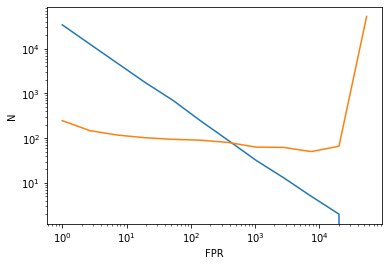

In [13]:
plt.plot(1./fpr_edges, bg_thr, label=r'AUC = %0.2f'%(aucs[0])) #lw=2, alpha=.8))
plt.plot(1./fpr_edges, sg_thr, label=r'AUC = %0.2f'%(aucs[0])) #lw=2, alpha=.8))
plt.xlabel('FPR')
plt.ylabel('N')
#plt.ylim([0.9, 1.01])
#plt.xlim([1.e2, 1./5.e-5])#1./5.56096205e-05])
plt.xscale('log')
plt.yscale('log')
plt.show()

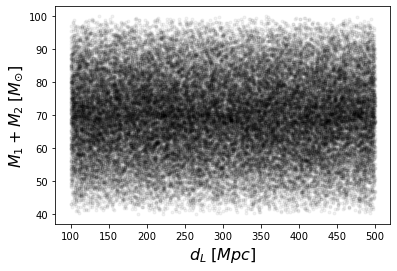

In [14]:
mtots = m1s+m2s
sg_mask = (y_trues == 1)
bg_mask = (y_trues == 0)
plt.plot(dists[sg_mask], mtots[sg_mask], ".", color='black', alpha=0.05, label='p')
plt.ylabel(r'$M_1 + M_2\;[M_{\odot}]$', size=16)
#plt.ylim([20.,1.e2])
plt.xlabel(r'$d_L\;[Mpc]$', size=16)
#plt.xlim([500.,1.e3])
plt.show()

In [15]:
def set_hist(h, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.16)
    #c.SetRightMargin(0.15)
    #c.SetBottomMargin(0.13)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    h.GetXaxis().SetLabelFont(42)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.09)
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetTitleFont(42)

    h.GetYaxis().SetLabelSize(0.04)
    h.GetYaxis().SetLabelFont(42)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleFont(42)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    h.SetTitleFont(62)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    #return h, c
    return h

In [16]:
import LIGO_style
#tdrstyle.setTDRStyle()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
LIGO_style.writeExtraText = 1
LIGO_style.extraText = "Hanford"
LIGO_style.cmsTextOffset = 0.
#t_total = 8*4096 # s
t_total = int(0.5*len(idxs_val)/2)
t_total_h = t_total//(60*60) # h
t_total_m = (t_total%(60*60))//60 # m
t_total_s = t_total_m%(60) # s
t_total_str = '%sh%sm%ss'%(t_total_h, t_total_h, t_total_s)
LIGO_style.lumi_sqrtS = "%s (O1)"%t_total_str # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#iPos = 11 # inside frame
iPos = 0 # above frame
if iPos==0: LIGO_style.relPosX = 0.16
iPeriod = 0
print(t_total_str)

7h7m29s


In [17]:
h, c, hc = {}, {}, {}
line, legend = {}, {}
nbins = 20
wd, ht = int(480*1), int(420*1)
'''
# bg
k = 'nn-bg'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)
for i in range(len(y_probs[bg_mask])):
    #if i > 1e4: break
    h[k].Fill(y_probs[bg_mask][i])

# sg
k = 'nn-sg'
h[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)
for i in range(len(y_probs[sg_mask])):
    #if i > 1e4: break
    h[k].Fill(y_probs[sg_mask][i])'''

"\n# bg\nk = 'nn-bg'\nc[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)\nh[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)\nfor i in range(len(y_probs[bg_mask])):\n    #if i > 1e4: break\n    h[k].Fill(y_probs[bg_mask][i])\n\n# sg\nk = 'nn-sg'\nh[k] = ROOT.TH1F('h'+k, 'h'+k, nbins, 0., 1.)\nfor i in range(len(y_probs[sg_mask])):\n    #if i > 1e4: break\n    h[k].Fill(y_probs[sg_mask][i])"

In [18]:
fprinv_edges = (1./fpr_edges)[::-1]
fprinv_edges[-1] = 1.e6
print(fprinv_edges)

hsg = sg_thr[::-1]
print(hsg)
hbg = bg_thr[::-1]
print(hbg)
# NOTE: in this binning, bin_val | edge_i < bin_val <= edge_i+1
# i.e. inclusive on upper edge, rather than on lower edge, so that
# (1) top bg scores are histogrammed below FPinv max
# (2) top sg scores dont go into overflow bin
nbins = len(fprinv_edges)-1
fprinv_edges = array('d', fprinv_edges)

k = 'nsgvfprinv'
h[k] = ROOT.TH1F(k, k, nbins, fprinv_edges)

k = 'nbgvfprinv'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, 480, 420)
h[k] = ROOT.TH1F(k, k, nbins, fprinv_edges)

for i in range(nbins):
    h['nsgvfprinv'].SetBinContent(i+1, hsg[i])
    h['nbgvfprinv'].SetBinContent(i+1, hbg[i])

[1.00000000e+00 2.69406006e+00 7.25795958e+00 1.95533790e+01
 5.26779773e+01 1.41917634e+02 3.82334630e+02 1.03003246e+03
 2.77496929e+03 7.47593393e+03 2.01406150e+04 5.42600263e+04
 1.00000000e+06]
[  246   147   117   102    94    90    80    63    62    50    66 52574
     0]
[34103 12628  4697  1747   700   243    89    32    13     5     2     0
     0]


/export/home/phys/mbandrews/miniconda3/envs/gw-pyt/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


7h7m29s (O1)


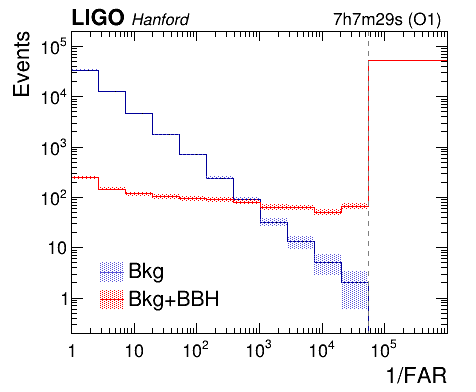

In [19]:
err_style = 'E2'
fill_style = 3002
LIGO_style.relPosX = 0.16

k = 'nbgvfprinv'
c[k].cd()
#h[k] = set_hist(h[k], 'FAR^{-1}', 'Events', '')
h[k] = set_hist(h[k], '1/FAR', 'Events', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.06) # without colz
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetErrorX(0.5)
ROOT.gPad.SetLogx()
ROOT.gPad.SetLogy()

ymin, ymax = 2.e-1, 2.e5
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.1)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetMaxDigits(3)

h[k].GetXaxis().SetTitleOffset(1.1)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-405)
#h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "10^{#infty}")
h[k].GetXaxis().ChangeLabel(-1,-1,0,-1,-1,-1, "")

# bg, line
h[k].Draw('hist')
# bg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetLineColor(9)
hc[k].SetFillColor(9)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nsgvfprinv'
# sg, line
h[k].SetLineColor(2)
h[k].Draw('hist same')
# sg, band
hc[k] = h[k].Clone()
hc[k].SetName(k+'band')
hc[k].SetMarkerStyle(1)
hc[k].SetMarkerSize(0)
hc[k].SetMarkerColor(2)
hc[k].SetLineColor(2)
hc[k].SetFillColor(2)
hc[k].SetFillStyle(fill_style)
hc[k].Draw("%s same"%err_style)

k = 'nbgvfprinv'
legend[k] = ROOT.TLegend(0.2,0.2,0.2+0.28,0.2+0.14) #(x1, y1, x2, y2)
legend[k].AddEntry(hc['nbgvfprinv'].GetName(), "Bkg",     "lf")
legend[k].AddEntry(hc['nsgvfprinv'].GetName(), "Bkg+BBH", "lf")
legend[k].SetBorderSize(0)
legend[k].SetTextFont(42)
legend[k].Draw("same")

kl1 = k+'l1'
line[kl1] = ROOT.TLine(fprinv_edges[-5], 0., fprinv_edges[-5], ymax) # x0,y0, x1,y1
line[kl1].SetLineColor(14)
line[kl1].SetLineStyle(7)
#line[kl1].Draw("same")

kl2 = k+'l2'
line[kl2] = ROOT.TLine(fprinv_max, 0., fprinv_max, ymax) # x0,y0, x1,y1
line[kl2].SetLineColor(14)
line[kl2].SetLineStyle(7)
line[kl2].Draw("same")

c[k].RedrawAxis()
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [20]:
y_probs_sg_sorted = np.sort(y_probs_sg)
print(y_probs_sg_sorted[0], y_probs_sg_sorted[-1])
print(len(y_probs_sg_sorted), int(0.1*len(y_probs_sg_sorted)))
y_probs_top10pc_thr = y_probs_sg_sorted[-int(0.1*len(y_probs_sg_sorted))]
print(y_probs_top10pc_thr)
print(len(y_probs_sg_sorted[y_probs_sg_sorted==1.]))

5.456965174871486e-13 1.0
53692 5369
1.0
51637


In [21]:
wd, ht = int(480*1), int(400*1)

thr_fprinv_glitch = thr_coarse[-5] #0.96222246

k = 'sgeffFPRinvmax'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)
dists_sg = dists[sg_mask]
mtots_sg = mtots[sg_mask]
y_probs_sg = y_probs[sg_mask]
for i in range(len(mtots[sg_mask])):
    # top k
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] >= y_probs_top10pc_thr else 0.)
    # high-purity regime
    h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] > thr_fprinvmax else 0.)
    # glitch regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (y_probs_sg[i] < thr_fprinvmax and y_probs_sg[i] >= thr_fprinv_glitch) else 0.)
    # nois regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] < thr_fprinv_glitch else 0.)

print(h[k].GetMinimum(), h[k].GetMaximum())

0.7787610619469026 1.0


7h7m29s (O1)


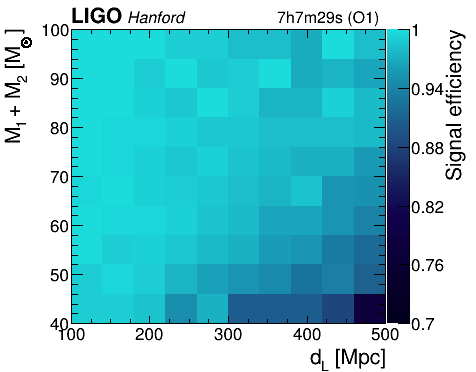

In [22]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'sgeffFPRinvmax'

c[k].cd()
h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0) #0:set False, 1:set True

ymin, ymax = 40., 100.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
#h[k].GetYaxis().ChangeLabel(1,-1,0,-1,-1,-1, "")

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)

h[k].GetZaxis().SetTitle('Signal efficiency')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-5)

h[k].SetMaximum(1.)
h[k].SetMinimum(0.7)
h[k].SetContour(100)
h[k].Draw('COLZ')

#h[k].SetContour(6)
#h[k].Draw('CONT3')

c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [23]:
wd, ht = int(480*1), int(400*1)

#thr_fprinv_glitch = thr_coarse[-5] #0.96222246

k = 'decraFPRinvmax'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 0, 2*np.pi, 20, -np.pi/2., np.pi/2)
decs_sg = decs[sg_mask]
ras_sg = ras[sg_mask]
#y_probs_sg = y_probs[sg_mask]
for i in range(len(decs_sg)):
    # top k
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] >= y_probs_top10pc_thr else 0.)
    # high-purity regime
    #if decs_sg[i] > np.pi/2: continue
    dec_ = decs_sg[i] if decs_sg[i] < np.pi/2. else decs_sg[i] - np.pi
    #dec_ = decs_sg[i] if decs_sg[i] < np.pi/2. else np.pi/2 - decs_sg[i]
    h[k].Fill(ras_sg[i], dec_, 1. if y_probs_sg[i] > thr_fprinvmax else 0.)
    # glitch regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if (y_probs_sg[i] < thr_fprinvmax and y_probs_sg[i] >= thr_fprinv_glitch) else 0.)
    # nois regime
    #h[k].Fill(dists_sg[i], mtots_sg[i], 1. if y_probs_sg[i] < thr_fprinv_glitch else 0.)
    #print(decs_sg[i], ras_sg[i])
    #if i>10: break

print(h[k].GetMinimum(), h[k].GetMaximum())

0.8687943262411347 1.0


7h7m29s (O1)


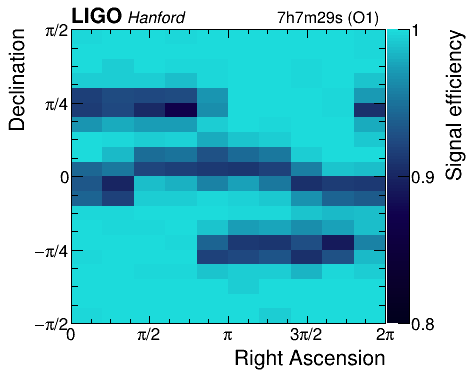

In [24]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'decraFPRinvmax'

c[k].cd()
h[k] = set_hist(h[k], 'Right Ascension', 'Declination', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.gStyle.SetPalette(51)#53:kDarkBodyRadiator, 51:kDeepSea, 52:Gray
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)
ROOT.gPad.SetLogz(0) #0:set False, 1:set True

ymin, ymax = 40., 100.
#h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetNdivisions(-404)
h[k].GetYaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "-#pi/2")
h[k].GetYaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "-#pi/4")
h[k].GetYaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "0")
h[k].GetYaxis().ChangeLabel(4,-1,-1,-1,-1,-1, "#pi/4")
h[k].GetYaxis().ChangeLabel(5,-1,-1,-1,-1,-1, "#pi/2")

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)
h[k].GetXaxis().ChangeLabel(1,-1,-1,-1,-1,-1, "0")
h[k].GetXaxis().ChangeLabel(2,-1,-1,-1,-1,-1, "#pi/2")
h[k].GetXaxis().ChangeLabel(3,-1,-1,-1,-1,-1, "#pi")
h[k].GetXaxis().ChangeLabel(-2,-1,-1,-1,-1,-1, "3#pi/2")
h[k].GetXaxis().ChangeLabel(-1,-1,-1,-1,-1,-1, "2#pi")

h[k].GetZaxis().SetTitle('Signal efficiency')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-2)

h[k].SetMaximum(1.)
h[k].SetMinimum(0.8)
h[k].SetContour(100)
h[k].Draw('COLZ')

#h[k].SetContour(6)
#h[k].Draw('CONT3')

c[k].Draw()
c[k].Update()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)

In [25]:
wd, ht = int(480*1), int(400*1)

k = 'limits'
c[k] = ROOT.TCanvas('c'+k, 'c'+k, wd, ht)
#h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 500, 1.e3, 10, 20, 100)
h[k] = ROOT.TProfile2D('h'+k, 'h'+k, 10, 100, 500, 10, 40, 100)
for i in range(len(mtots[sg_mask])):
    h[k].Fill(dists[sg_mask][i], mtots[sg_mask][i], y_probs[sg_mask][i])

7h7m29s (O1)


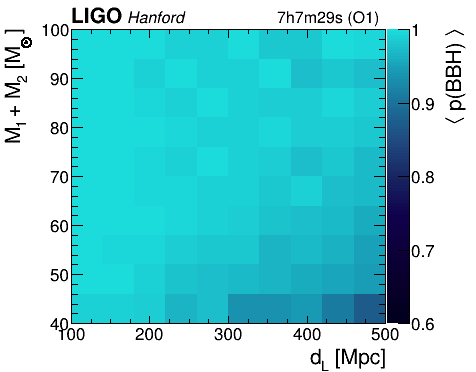

In [26]:
if iPos==0: LIGO_style.relPosX = 0.18

k = 'limits'

c[k].cd()
h[k] = set_hist(h[k], 'd_{L} [Mpc]', 'M_{1} + M_{2} [M_{#odot} ]', '')
ROOT.gPad.SetTopMargin(0.08)
ROOT.gPad.SetBottomMargin(0.13)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.19) # with colz
#ROOT.gPad.SetRightMargin(0.1) # without colz
ROOT.gStyle.SetPalette(51)#53
ROOT.TGaxis.fgMaxDigits = 3
ROOT.gStyle.SetOptStat(0)

ymin, ymax = 40., 100.
h[k].GetYaxis().SetRangeUser(ymin, ymax)
h[k].GetYaxis().SetTitleOffset(1.2)
h[k].GetYaxis().SetTitleSize(0.06)
h[k].GetYaxis().SetLabelSize(0.05)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)

h[k].GetZaxis().SetTitle('#LT p(BBH) #GT')
h[k].GetZaxis().SetTitleOffset(1.)
h[k].GetZaxis().SetTitleSize(0.06)
h[k].GetZaxis().SetLabelSize(0.05)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetZaxis().SetNdivisions(-4)

h[k].GetXaxis().SetTitleOffset(1.0)
h[k].GetXaxis().SetTitleSize(0.06)
h[k].GetXaxis().SetLabelSize(0.05)
h[k].GetXaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetNdivisions(-404)

h[k].SetMaximum(1.)
h[k].SetMinimum(0.6)
h[k].SetContour(100)

h[k].Draw('COLZ')
c[k].Draw()

LIGO_style.LIGO_style(c[k], iPeriod, iPos)